In [7]:
from qibo.gates import I, X, RX, RY, M, CZ, Y, Z
import numpy as np
from qibo.models import Circuit
from itertools import product

from utils.qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

api = API(ConnectionConfiguration(username="qat", api_key="meow"))
api.select_device_id(9)

#### Constants

In [9]:
NUM_SHOTS = 1000

#### Define basic gate sequence

In [10]:
def six_operators(qubit):
    return [
        I(qubit),
        X(qubit),
        RX(qubit, np.pi/2),
        RX(qubit, -np.pi/2), 
        RY(qubit, np.pi / 2),
        RY(qubit, -np.pi / 2)
    ]

#### Define circuits for process tomography of the CZ gate and for obtaining the SPAM matrix

In [11]:
def process_tomography(pa, pb, qubit_a, qubit_b):
    circuits = []

    for op1_a in six_operators(qubit_a):
        for op1_b in six_operators(qubit_b):
            circuit = Circuit(5)
            circuit.add(pa)  # PA
            circuit.add(pb)  # PB
            circuit.add(CZ(qubit_a, qubit_b))
            circuit.add(op1_a)  # RA
            circuit.add(op1_b)  # RB
            circuit.add(M(qubit_a, qubit_b))

            circuits.append(circuit)
    return circuits

def spam_matrix_circuits(qubit_a, qubit_b):
    circuits = []
    for gate_a in [I, X]:
        for gate_b in [I, X]:
            circuit = Circuit(5)
            circuit.add(gate_a(qubit_a))
            circuit.add(gate_b(qubit_b))
            circuit.add(M(qubit_a, qubit_b))

            circuits.append(circuit)

    return circuits

#### Run sequences
We separate the data coming from each post-CZ basis state reconstruction in order to go around the 100 circuit limit per execute call.

In [ ]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

spam_job_ids = {}
qpt_job_ids = {}


for qubit_pair in qubit_pairs:
    QUBIT_A, QUBIT_B = qubit_pair
    
    ## Run SPAM measurements, store ID  
    spam_circuits = spam_matrix_circuits(QUBIT_A, QUBIT_B)
    result_id = api.execute(spam_circuits, nshots=NUM_SHOTS)[0]
    spam_job_ids[str(qubit_pair)] = result_id
    
    qst_jobids = {}

    ## Run QPT measurements, store ID  
    for i, pa in enumerate(six_operators(QUBIT_A)):
        for j, pb in enumerate(six_operators(QUBIT_B)):
            state_tomography_circuits = process_tomography(pa, pb, QUBIT_A, QUBIT_B)
            result_id = api.execute(state_tomography_circuits, nshots=NUM_SHOTS)[0]
            
            qst_jobids[str((i, j))] = result_id
    
    qpt_job_ids[str(qubit_pair)] = qst_jobids
            

In [ ]:
fname_saveids = './qpt_job_ids'
np.savez(fname_saveids, qpt_job_ids=qpt_job_ids, spam_job_ids=spam_job_ids, qubit_pairs=qubit_pairs)

In [12]:
# reconnect()
df_ids = api.list_jobs().dataframe
ids = df_ids['id']
ids_arr = ids.to_numpy()

##### Retrieve job ids if run at some other time

In [13]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]
qubit_pairs.reverse()

spam_job_ids = {}
qpt_job_ids = {}

last_id = int(ids_arr[0])
result_id = last_id

for k, qubit_pair in enumerate(qubit_pairs):
    QUBIT_A, QUBIT_B = qubit_pair
    
    qst_jobids = {}

    ## Run QPT measurements, store ID  
    for i in np.arange(5, -1, -1):
        for j in np.arange(5, -1, -1):
            qst_jobids[str((i, j))] = result_id
            result_id -= 1
    qpt_job_ids[str(qubit_pair)] = qst_jobids
    
    
    ## Run SPAM measurements, store ID 
    spam_job_ids[str(qubit_pair)] = result_id
    result_id -= 1 
       

In [23]:
for i in range(5849, 5870):
    api.get_job(i)

Your job with id 5849 is completed.
Your job with id 5850 is completed.
Your job with id 5851 is completed.
Your job with id 5852 is completed.
Your job with id 5853 is completed.
Your job with id 5854 is completed.
Your job with id 5855 is completed.
Your job with id 5856 is completed.
Your job with id 5857 is completed.
Your job with id 5858 is completed.
Your job with id 5859 is completed.
Your job with id 5860 is completed.
Your job with id 5861 is completed.
Your job with id 5862 is completed.
Your job with id 5863 is completed.
Your job with id 5864 is completed.
Your job with id 5865 is completed.
Your job with id 5866 is completed.
Your job with id 5867 is completed.
Your job with id 5868 is completed.
Your job with id 5869 is completed.


In [19]:
spam_job_ids['(2, 3)']
qpt_job_ids['(2, 3)']

{'(5, 5)': 5884,
 '(5, 4)': 5883,
 '(5, 3)': 5882,
 '(5, 2)': 5881,
 '(5, 1)': 5880,
 '(5, 0)': 5879,
 '(4, 5)': 5878,
 '(4, 4)': 5877,
 '(4, 3)': 5876,
 '(4, 2)': 5875,
 '(4, 1)': 5874,
 '(4, 0)': 5873,
 '(3, 5)': 5872,
 '(3, 4)': 5871,
 '(3, 3)': 5870,
 '(3, 2)': 5869,
 '(3, 1)': 5868,
 '(3, 0)': 5867,
 '(2, 5)': 5866,
 '(2, 4)': 5865,
 '(2, 3)': 5864,
 '(2, 2)': 5863,
 '(2, 1)': 5862,
 '(2, 0)': 5861,
 '(1, 5)': 5860,
 '(1, 4)': 5859,
 '(1, 3)': 5858,
 '(1, 2)': 5857,
 '(1, 1)': 5856,
 '(1, 0)': 5855,
 '(0, 5)': 5854,
 '(0, 4)': 5853,
 '(0, 3)': 5852,
 '(0, 2)': 5851,
 '(0, 1)': 5850,
 '(0, 0)': 5849}

#### Retrieve data and analyse it

In [ ]:
f = np.load(fname_saveids)
spam_job_ids = f['spam_job_ids']
qpt_job_ids = f['qpt_job_ids']

In [72]:
state_reconstruction_paulibasis = np.zeros((len(qubit_pairs), 36, 16))

ideal_operator = CZ(0, 1).matrix
R_ideal = get_ideal_R_matrix(ideal_operator)

reconstructed_Rs = np.zeros((len(qubit_pairs), 16, 16))
fidelities = {}

qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

for pair_index, qubit_pair in enumerate(qubit_pairs):

    spam_id = spam_job_ids[str(qubit_pair)]
    spam_results = api.get_result(spam_id)
    spam_data_probabilities = process_returned_dataformat(spam_results, nqubits=2)
    measurement_calibration_weights = np.linalg.pinv(spam_data_probabilities)
    
    for P_index, (pa_index, pb_index) in enumerate(product(range(6), repeat=2)):
        
        qst_papb_id = qpt_job_ids[str(qubit_pair)][str((pa_index, pb_index))]
        qst_papb_results = api.get_result(qst_papb_id)
        qst_papb_probabilities = process_returned_dataformat(qst_papb_results, nqubits=2)
        qst_papb_expectedobs = convert_probabilities2measurementops(qst_papb_probabilities)
        
        coeff_matrix, independent_term = prepare_linear_system_QST(measurement_calibration_weights, qst_papb_expectedobs)
        
        ## solve linear system QST
        reconstructed_state_paulibasis_noII = np.linalg.pinv(coeff_matrix) @ independent_term
        state_reconstruction_paulibasis[pair_index, P_index] = np.append(1/4, reconstructed_state_paulibasis_noII)
        
    coeffs_mat, independent_term = prepare_linear_system_QPT(state_reconstruction_paulibasis[pair_index])
    Rvec = np.linalg.pinv(coeffs_mat) @ independent_term
    reconstructed_R = Rvec.reshape(16, 16)
    reconstructed_Rs[pair_index] = reconstructed_R
    
    process_fidelity = compute_process_fidelity(R_ideal, reconstructed_R)
    fidelities[str(qubit_pair)] = process_fidelity
                

Your job with id 5774 is completed.
Your job with id 5775 is completed.
Your job with id 5776 is completed.
Your job with id 5777 is completed.
Your job with id 5778 is completed.
Your job with id 5779 is completed.
Your job with id 5780 is completed.
Your job with id 5781 is completed.
Your job with id 5782 is completed.
Your job with id 5783 is completed.
Your job with id 5784 is completed.
Your job with id 5785 is completed.
Your job with id 5786 is completed.
Your job with id 5787 is completed.
Your job with id 5788 is completed.
Your job with id 5789 is completed.
Your job with id 5790 is completed.
Your job with id 5791 is completed.
Your job with id 5792 is completed.
Your job with id 5793 is completed.
Your job with id 5794 is completed.
Your job with id 5795 is completed.
Your job with id 5796 is completed.
Your job with id 5797 is completed.
Your job with id 5798 is completed.
Your job with id 5799 is completed.
Your job with id 5800 is completed.
Your job with id 5801 is com

TypeError: object of type 'NoneType' has no len()

In [75]:
import matplotlib.pyplot as plt

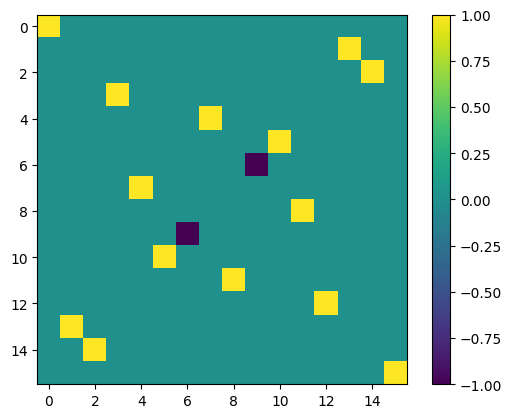

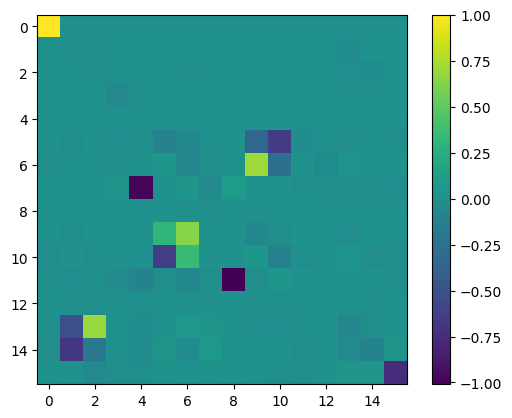

In [82]:
plt.imshow(R_ideal)
plt.colorbar()

plt.figure()
plt.imshow(reconstructed_Rs[1])
plt.colorbar()

In [73]:
print(fidelities)

{'(0, 2)': -0.09241067531125387, '(1, 2)': -0.32548004463035995}
